In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [61]:
###Training Set###

#Read the complete DataSet
df_train=pd.read_csv('Data/2C_Training.csv')
print('Training Data Set:\n',df_train.head()) #Applied Volts,Coulombs and Amps for all IGBTs
train_time=df_train['time']

#Separate out training Features as a dataframe: 09V-44V,Coulombs
df_xtrain = df_train.loc[:,'09V':'Coulombs']
print('df_xtrain:\n',df_xtrain.head())

#Separate out targets from the training set App_Amps for all IGBTs
df_ytrain = df_train.loc[:,'09A':'44A']
print('df_ytrain:\n',df_ytrain.head())

### Validation Data Set ###

#Read in the complete test dataset
df_test=pd.read_csv('Data/2C_Validation.csv')
test_time=df_test['time']
print('Validation Data Set:\n',df_test.head())

#Separate out features as a dataframe 09V-44V,Coulombs
df_xtest=df_test.loc[:,'09V':'Coulombs']
print('df_xtest:\n',df_xtest.head())

#separate out the targets from validation dataset App_Amps
df_ytest = df_test.loc[:,'09A':'44A']
print('df_ytest:\n',df_ytest.head())

Training Data Set:
    time  01V  02V  03V  04V  05V  06V  07V  08V  09V  ...  35A  36A  37A  38A  \
0     0    0    0    0    0    0    0    0    0   86  ...    0    0    0    0   
1     2    0    0    0    0    0    0    0    0  176  ...    0    0    0    0   
2     4    0    0    0    0    0    0    0    0  240  ...    0    0    0    0   
3     6    0    0    0    0    0    0    0    0  240  ...    0    0    0    0   
4     8    0    0    0    0    0    0    0    0  240  ...    0    0    0    0   

   39A  40A  41A  42A  43A  44A  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 91 columns]
df_xtrain:
    09V  10V  11V  12V  13V  14V  15V  16V  17V  18V  ...  36V  37V  38V  39V  \
0   86   86   86   86    0    0    0    0    0    0  ...    0    0    0    0   
1  176  176  176  176    0    0    0    0    0    0  ...    0    0    0    0   
2  240  240  2

Training Inputs (samples , features): (476, 37)
Training Outputs (samples , Targets): (476, 36)
Test Inputs (samples , features): (159, 37)
Test Outputs (samples , Targets): (159, 36)


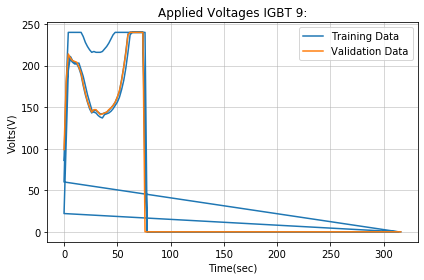

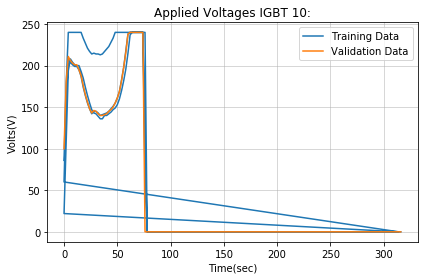

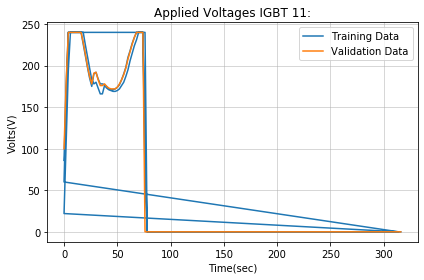

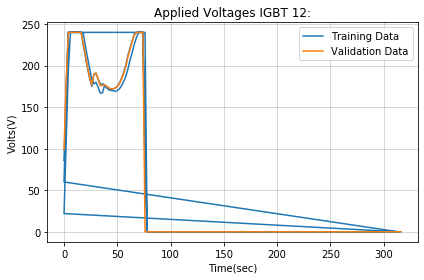

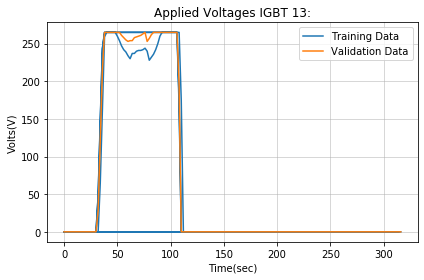

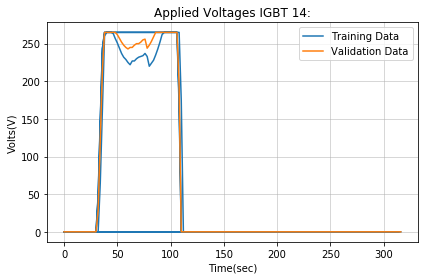

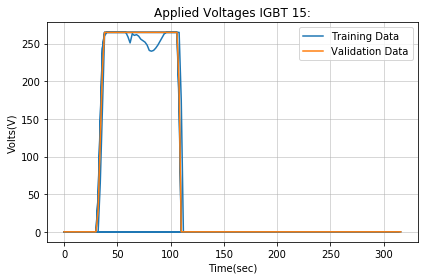

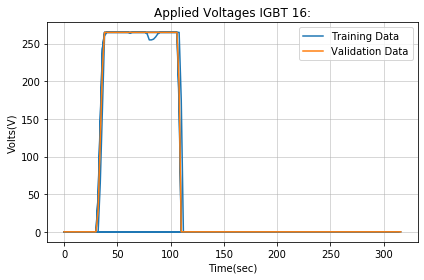

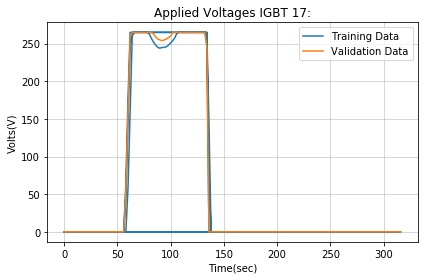

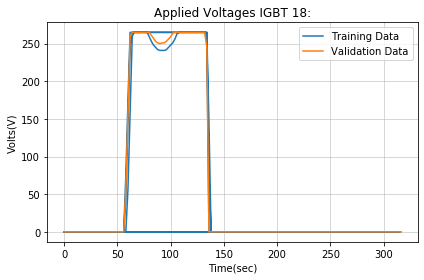

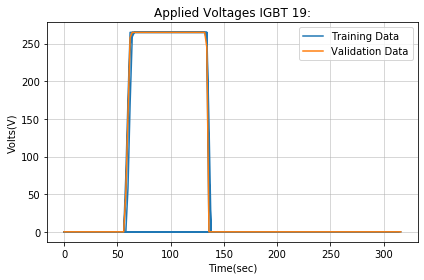

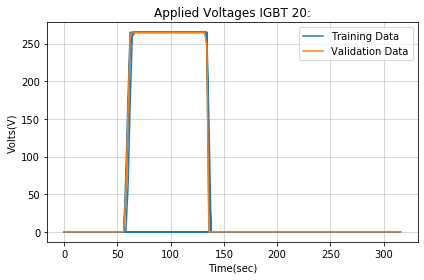

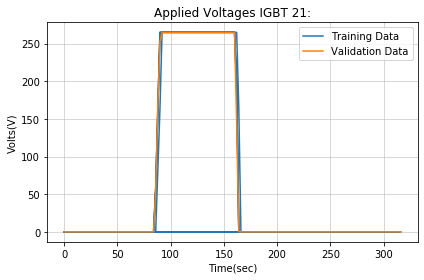

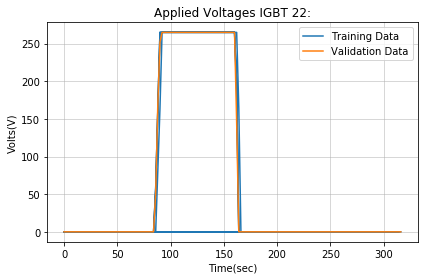

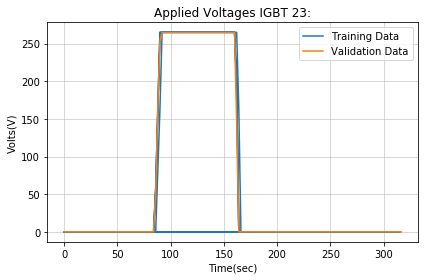

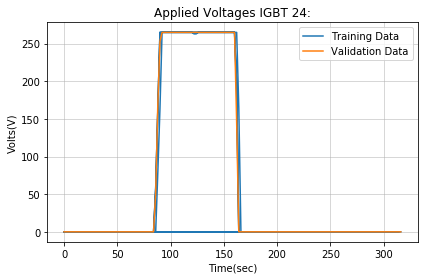

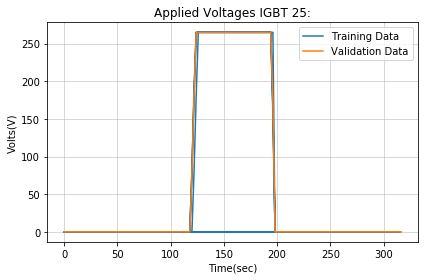

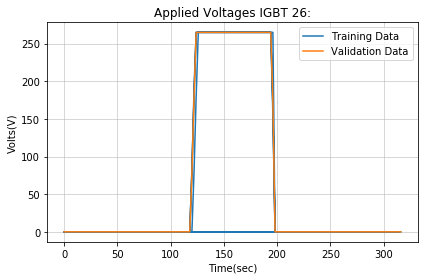

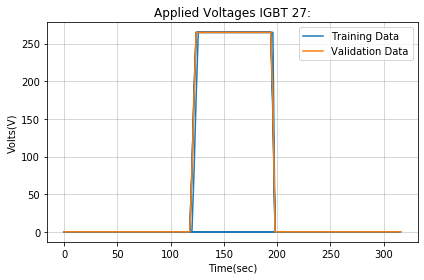

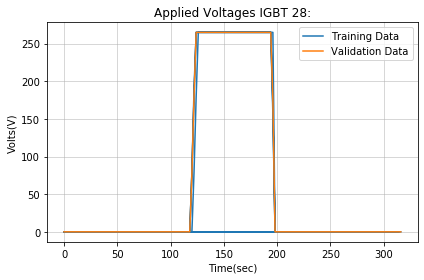

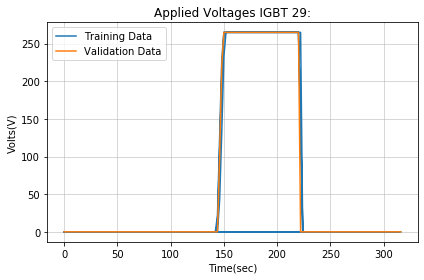

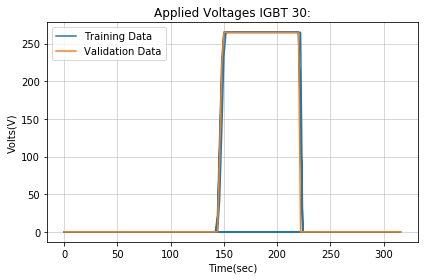

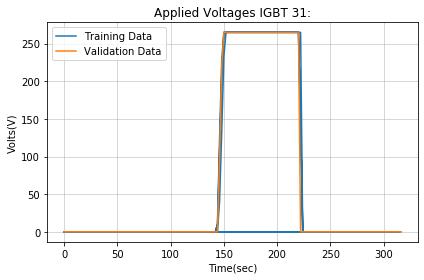

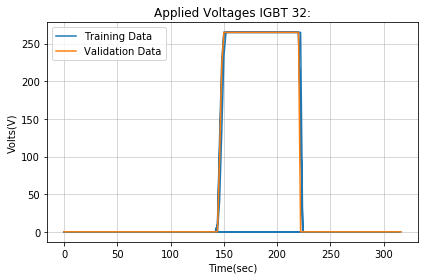

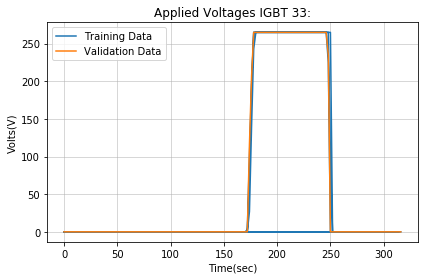

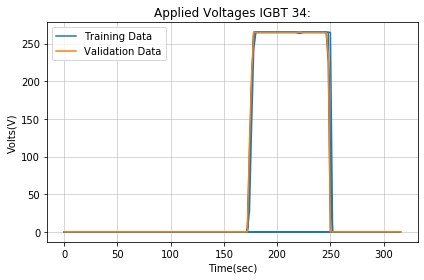

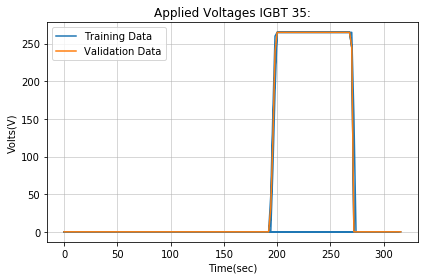

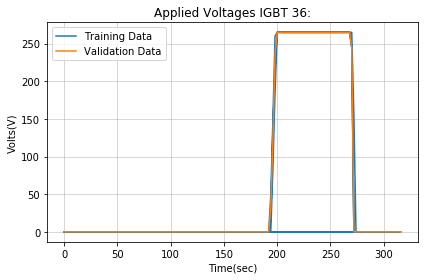

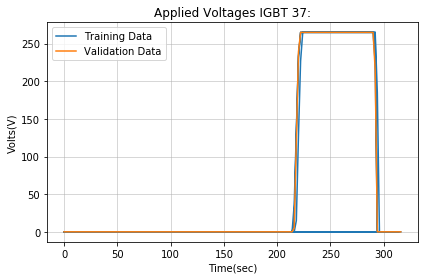

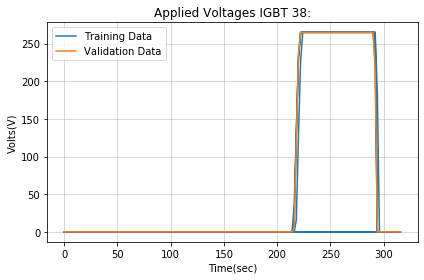

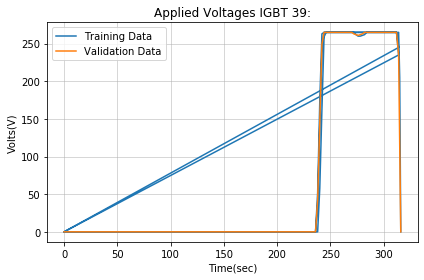

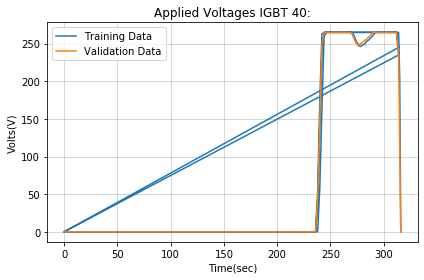

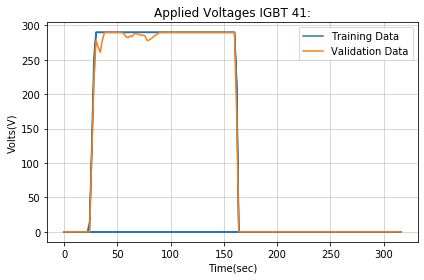

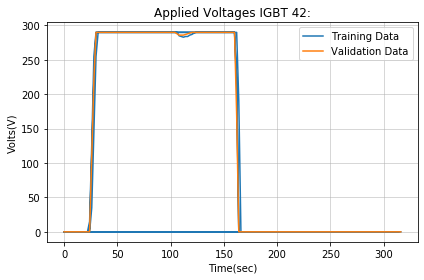

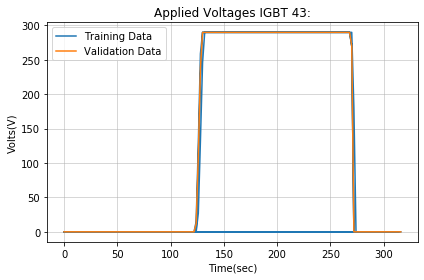

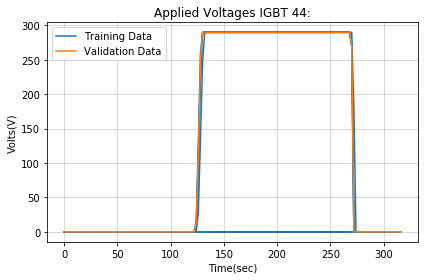

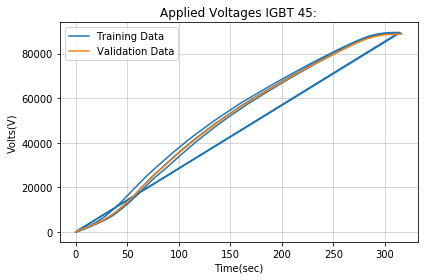

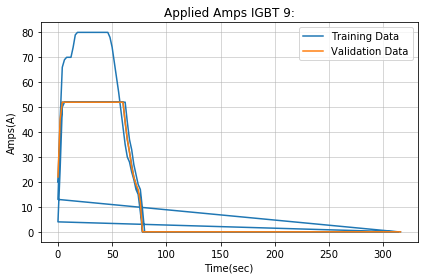

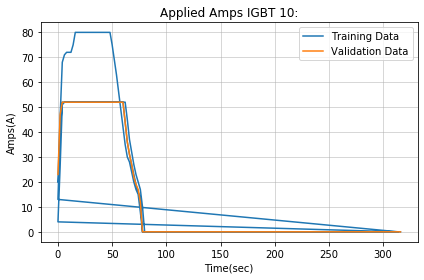

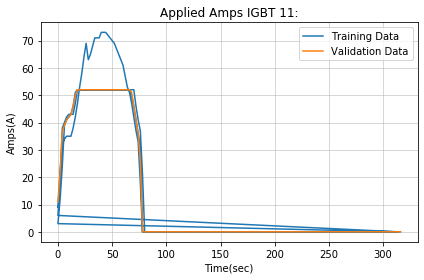

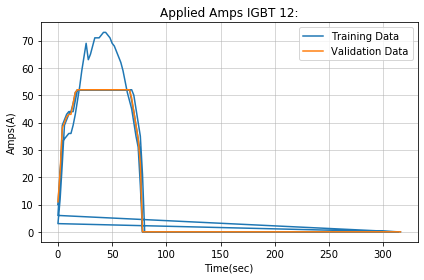

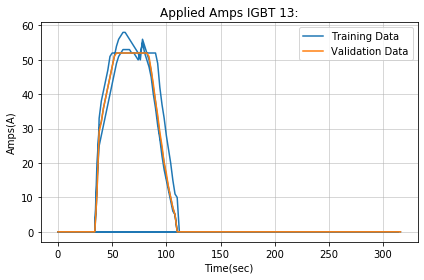

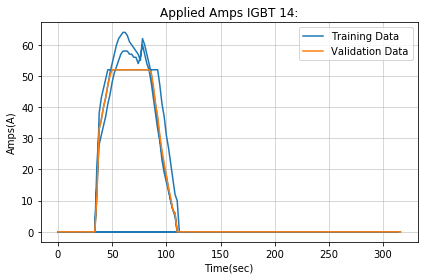

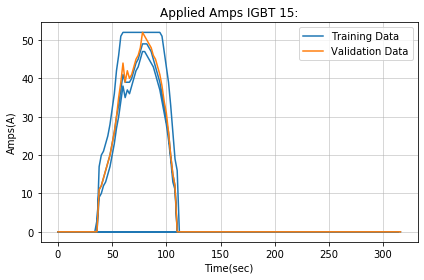

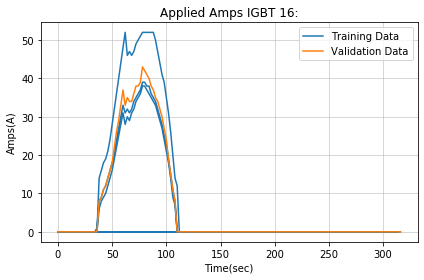

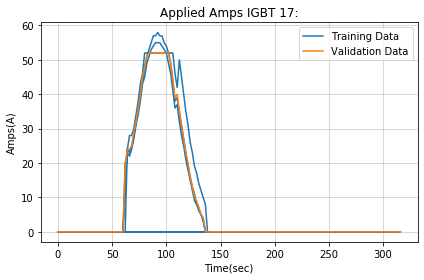

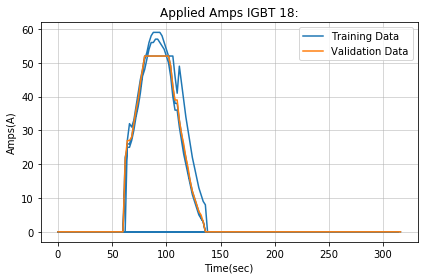

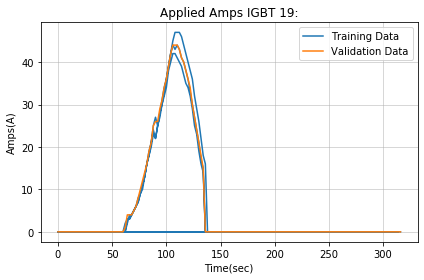

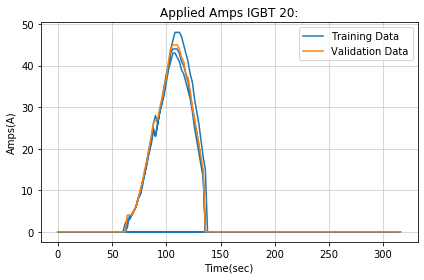

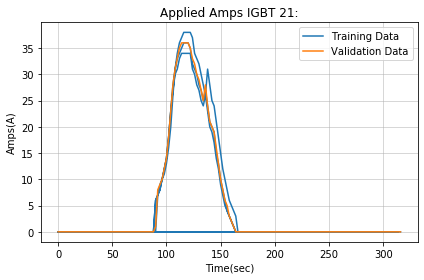

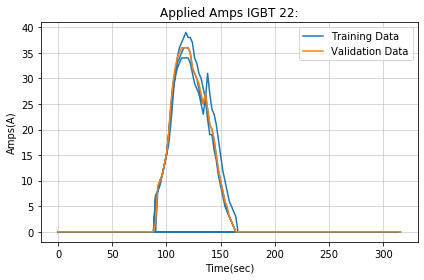

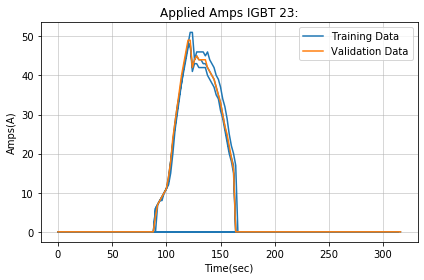

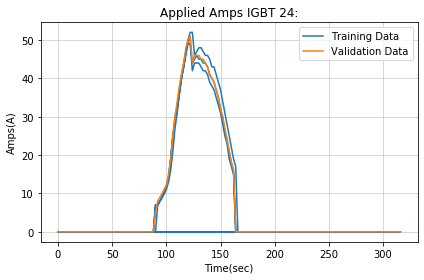

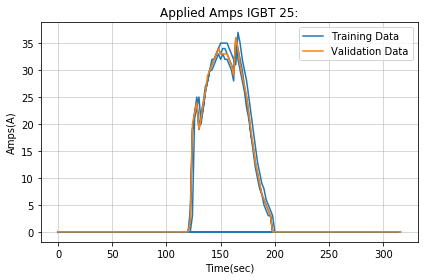

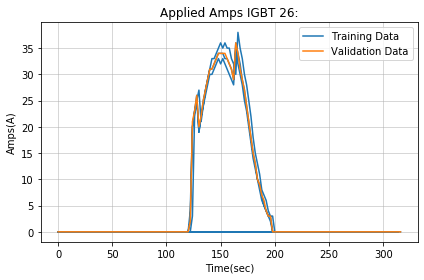

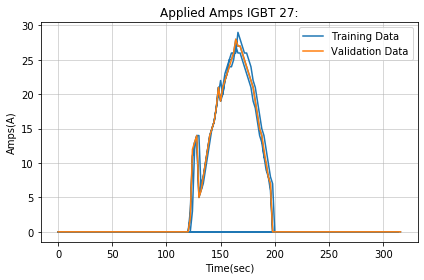

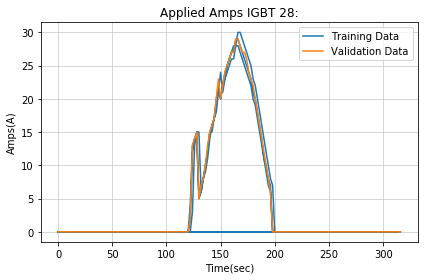

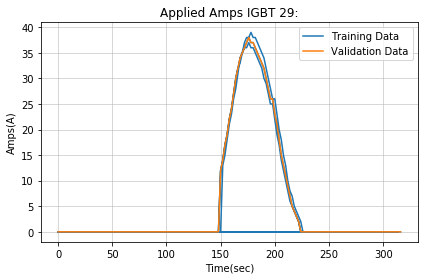

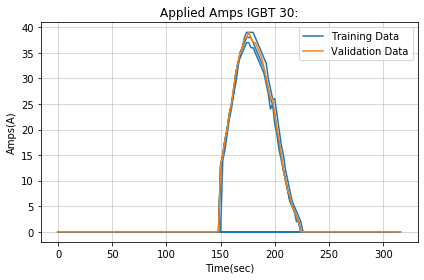

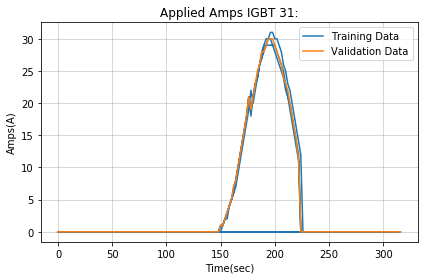

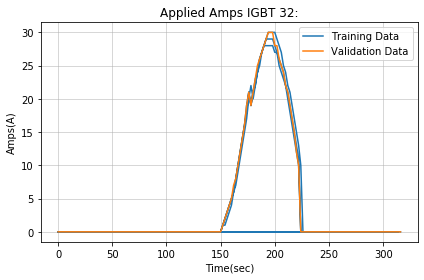

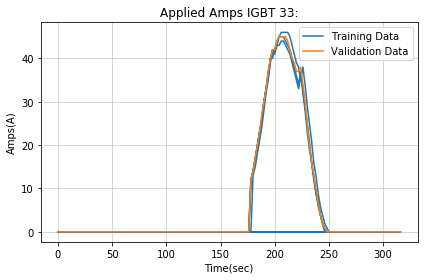

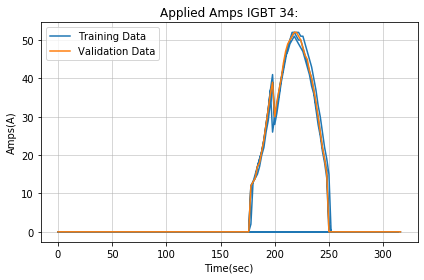

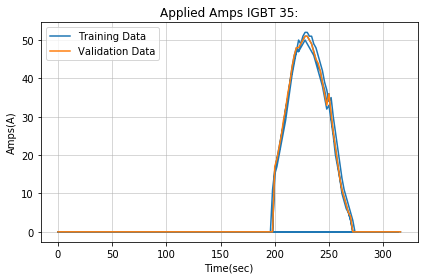

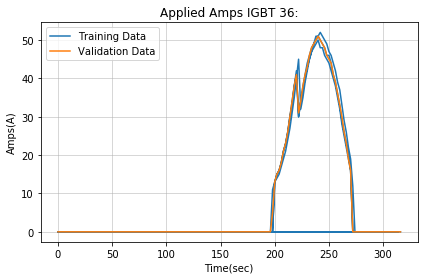

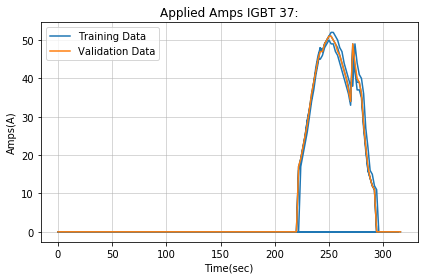

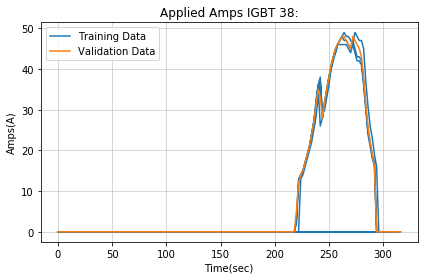

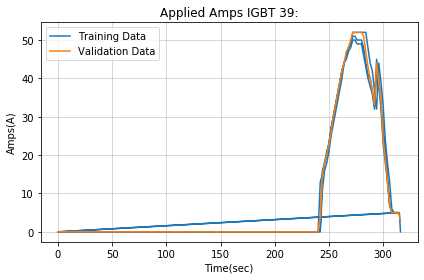

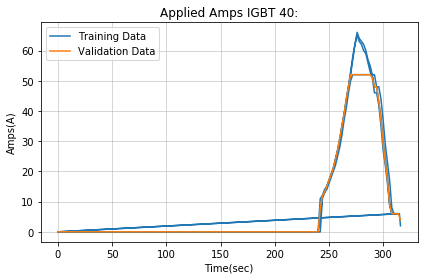

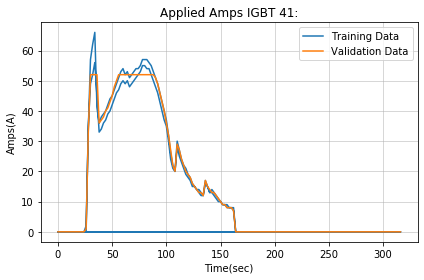

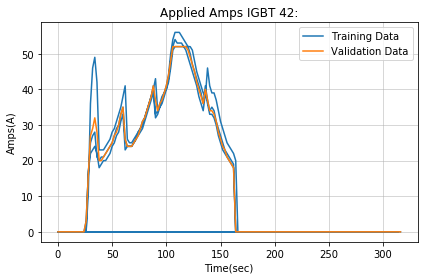

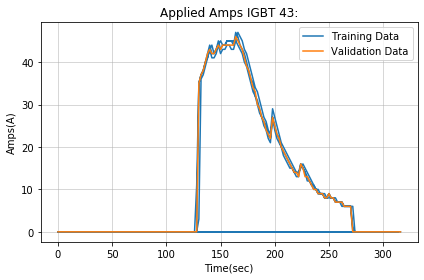

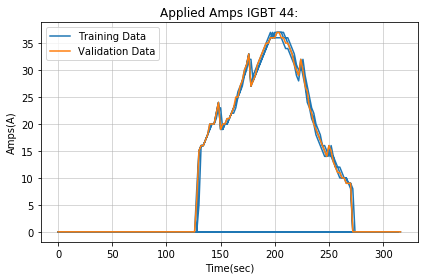

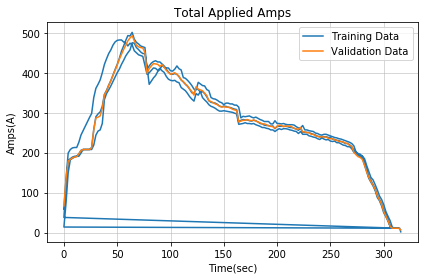

In [62]:
#convert features to a numpy array
xtrain=df_xtrain.values

#Reshape the array: no of samples x no of features
n_samples = len(df_xtrain.index)
n_features = len(df_xtrain.columns)
xtrain.reshape(n_samples,n_features)

#convert targets to a numpy array
ytrain=df_ytrain.values

#Rehsape array: samples x targets
n_targets = len(df_ytrain.columns)
ytrain.reshape(n_samples,n_targets)

#convert to a numpy array
xtest=df_xtest.values

#reshape array: Samples x Features
n_testsamples = len(df_xtest.index)
test_time = range(0,2*n_testsamples,2)
xtest.reshape(n_testsamples,n_features)

#convert targets to a numpy array
ytest=df_ytest.values

#Rehsape array: samples x targets
ytest.reshape(n_testsamples,n_targets)

print('Training Inputs (samples , features):',xtrain.shape)
print('Training Outputs (samples , Targets):',ytrain.shape)
print('Test Inputs (samples , features):',xtest.shape)
print('Test Outputs (samples , Targets):',ytest.shape)

#Visualise features
for i in range(n_features):
    plt.plot(train_time,xtrain[:,i],label='Training Data')
    plt.plot(test_time,xtest[:,i],label='Validation Data')
    plt.title('Applied Voltages IGBT %d:' %(i+9))
    plt.xlabel('Time(sec)')
    plt.ylabel('Volts(V)')
    plt.tight_layout()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()

#Visualise targets
for i in range(n_targets):
    plt.plot(train_time,ytrain[:,i],label='Training Data')
    plt.plot(test_time,ytest[:,i],label='Validation Data')
    plt.title('Applied Amps IGBT %d:' %(i+9))
    plt.xlabel('Time(sec)')
    plt.ylabel('Amps(A)')
    plt.tight_layout()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()
    
plt.plot(train_time,df_train['App_Amps'],label='Training Data')
plt.plot(test_time,df_test['App_Amps'],label='Validation Data')
plt.title('Total Applied Amps')
plt.xlabel('Time(sec)')
plt.ylabel('Amps(A)')
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

In [63]:
poly = PolynomialFeatures(2)

alphas = np.logspace(9,11,20000)
i=0

last_score_lr=100000000000.0000
last_score_quad=100000000000.0000

best_alpha_lr = 0
best_alpha_quad = 0


for alfa in alphas:
    rr_linear = linear_model.Ridge(alpha=alfa)
    rr_quad = make_pipeline(poly,linear_model.Ridge(alpha=alfa))
    
    rr_linear.fit(xtrain,ytrain)
    rr_quad.fit(xtrain,ytrain)
    
    ytest_lr=rr_linear.predict(xtest)
    ytest_lr.reshape(n_testsamples,n_targets)
    
    ytest_quad=rr_quad.predict(xtest)
    ytest_quad.reshape(n_testsamples,n_targets)
    
    yamps_lr=ytest_lr.sum(axis=1)
    yamps_quad=ytest_quad.sum(axis=1)
    
    Ridge_scores_lr = mean_absolute_error(df_test['App_Amps'],yamps_lr)
    Ridge_scores_quad = mean_absolute_error(df_test['App_Amps'],yamps_quad)
    
    if Ridge_scores_lr < last_score_lr:
        best_alpha_lr = alfa
    last_score_lr = Ridge_scores_lr
    
    if Ridge_scores_quad < last_score_quad:
        best_alpha_quad = alfa
    last_score_quad = Ridge_scores_quad
    
    i = i+1

print('Best Alpha Ridge Linear:',best_alpha_lr)
print('Best Alpha Ridge Quad:',best_alpha_quad)

Best Alpha Ridge Linear: 74027565915.5218
Best Alpha Ridge Quad: 2704715601.0340824


In [67]:
lr_model=LinearRegression().fit(xtrain,ytrain) #linear model

ridge_model_lr=Ridge(alpha=best_alpha_lr) #linear ridge model with optimized alpha
ridge_model_lr.fit(xtrain,ytrain)

ridgecv_model_lr=RidgeCV(alphas=np.logspace(7,11,20000),cv=7) #Ridge Model with 10 fold Cross Validation
ridgecv_model_lr.fit(xtrain,ytrain)

quad_model=make_pipeline(poly,LinearRegression()) #Quadratic Model
quad_model.fit(xtrain,ytrain) 

ridge_model_quad=make_pipeline(poly,Ridge(alpha=best_alpha_quad))#Quadratic Ridge model with Optimized Alpha
ridge_model_quad.fit(xtrain,ytrain)

ridgecv_model_quad=make_pipeline(poly,RidgeCV(alphas=np.logspace(7,11,20000),cv=7)) #Ridge Model with 10 fold Cross Validation
ridgecv_model_quad.fit(xtrain,ytrain) 

#Linear Model prediction
y_pred_linear=lr_model.predict(xtest)

#Linear Ridge Model with optimized Alpha 74027565915.5218
y_pred_ridge_lr=ridge_model_lr.predict(xtest)

#Linear Ridge Model with 7 fold cross validation
y_pred_ridgecv_lr=ridgecv_model_lr.predict(xtest)


#Quadratic Model Predictions
y_pred_quad=quad_model.predict(xtest)

#Quadratic Ridge Model with Optimized Alpha = 2704715601.0340824
y_pred_ridge_quad=ridge_model_quad.predict(xtest)


#Quadration ridge model with 7 fold Cross validation
y_pred_ridgecv_quad=ridgecv_model_quad.predict(xtest)

MAE = [linear_model_MAE,ridge_model_MAE_lr,ridgecv_model_MAE_lr,
      quad_model_MAE,ridge_model_MAE_quad,ridgecv_model_MAE]


KeyboardInterrupt: 

In [68]:
#Model Performance
#Linear Model
y_pred_amps_linear=y_pred_linear.sum(axis=1)
linear_model_MAE=mean_absolute_error(df_test['App_Amps'],y_pred_amps_linear)
print('MAE Linear Model',linear_model_MAE)

#Linear Ridge model with optimized alpha
y_pred_amps_ridge_lr=y_pred_ridge_lr.sum(axis=1)
ridge_model_MAE_lr=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridge_lr)
print('MAE Linear Rridge Model',ridge_model_MAE_lr)

#Linear Ridge model with CV
y_pred_amps_ridgecv_lr=y_pred_ridgecv_lr.sum(axis=1)
ridgecv_model_MAE_lr=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridgecv_lr)
print('MAE Linear Ridge CV Model',ridgecv_model_MAE_lr)

#Quadratic model
y_pred_amps_quad=y_pred_quad.sum(axis=1)
quad_model_MAE=mean_absolute_error(df_test['App_Amps'],y_pred_amps_quad)
print('MAE Quadratic Model',quad_model_MAE)

#Quadratic Model with Optimized alpha
y_pred_amps_ridge_quad=y_pred_ridge_quad.sum(axis=1)
ridge_model_MAE_quad=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridge_quad)
print('MAE Quadratic Rridge Model',ridge_model_MAE_quad)

#Quadratic Ridge Model with CV
y_pred_amps_ridgecv_quad=y_pred_ridgecv_quad.sum(axis=1)
ridgecv_model_MAE=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridgecv_quad)
print('MAE Quadratic Ridge CV Model',ridgecv_model_MAE)

MAE Linear Model 23.527585096525215
MAE Linear Rridge Model 69.42766667039355
MAE Linear Ridge CV Model 31.872977918482075
MAE Quadratic Model 7016.374024058008
MAE Quadratic Rridge Model 8.806406012433726
MAE Quadratic Ridge CV Model 11.562577218795777


Qadratic Ridge Model Alpha: 2704715601.0340824
Qadratic Ridge Model Mean Absolute Error: 8.806406012433726


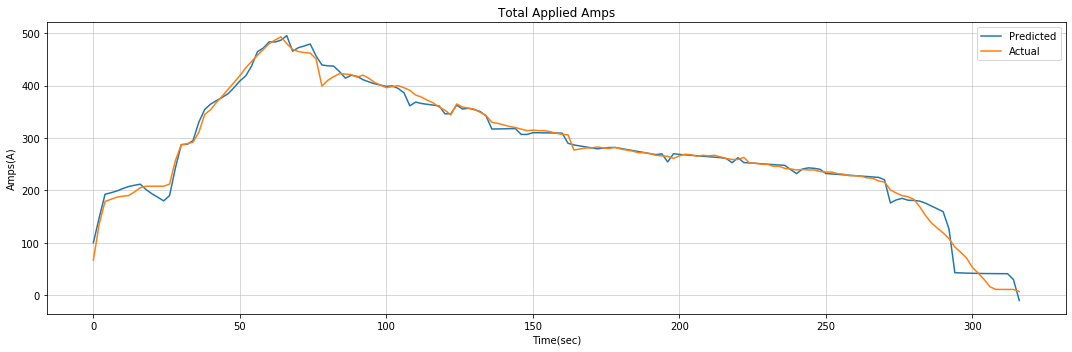

Absolute Error on Coulombs -11189.467572862282 A.sec
Percentage Error on Coulombs -0.1381680486540419 %


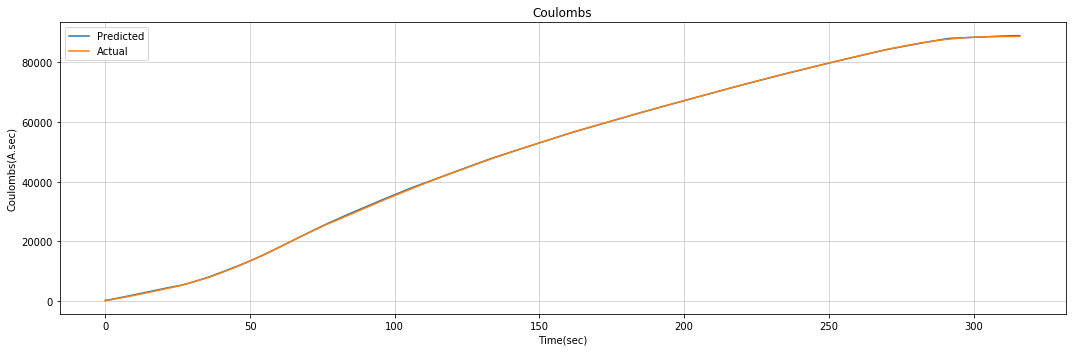

In [77]:
print('Qadratic Ridge Model Alpha:',best_alpha_quad)
print('Qadratic Ridge Model Mean Absolute Error:',ridge_model_MAE_quad)

plt.rcParams["figure.figsize"] = (15,5)
df_predict = pd.DataFrame(data=y_pred_ridge_quad,columns=df_ytest.columns,index=test_time)
df_predict['App_Amps']=df_predict.sum(axis=1)
df_predict['Coulombs']=df_predict['App_Amps'].mul(2).cumsum()
df_predict.head()

plt.plot(test_time,df_predict['App_Amps'],label='Predicted')
plt.plot(test_time,df_test['App_Amps'],label='Actual')
plt.title('Total Applied Amps')
plt.xlabel('Time(sec)')
plt.ylabel('Amps(A)')
plt.legend()
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.show()

Coulombs_error = df_test['Coulombs'].sum()-df_predict['Coulombs'].sum()
perc_error = (Coulombs_error/df_test['Coulombs'].sum())*100

print('Absolute Error on Coulombs',Coulombs_error,'A.sec')
print('Percentage Error on Coulombs',perc_error,'%')

plt.plot(test_time,df_predict['Coulombs'],label='Predicted')
plt.plot(test_time,df_test['Coulombs'],label='Actual')
plt.title('Coulombs')
plt.xlabel('Time(sec)')
plt.ylabel('Coulombs(A.sec)')
plt.legend()
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.show()


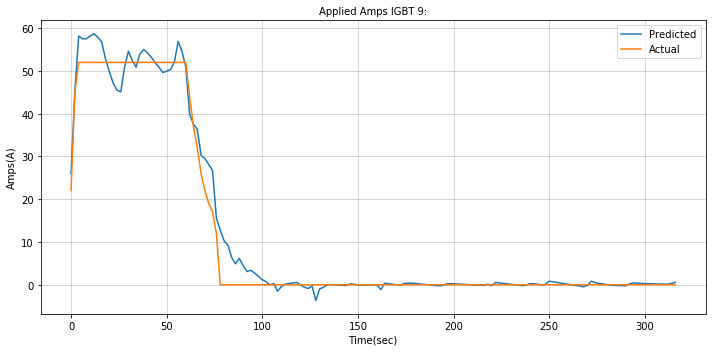

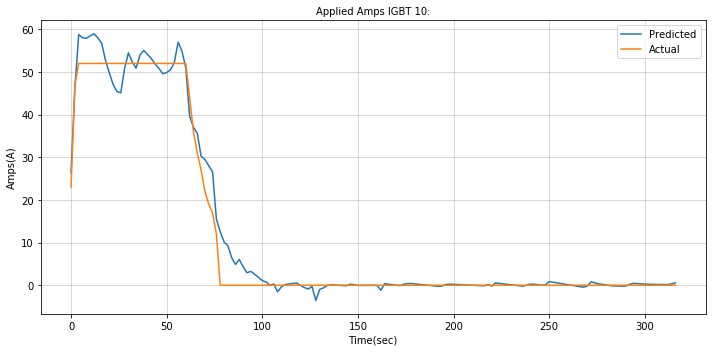

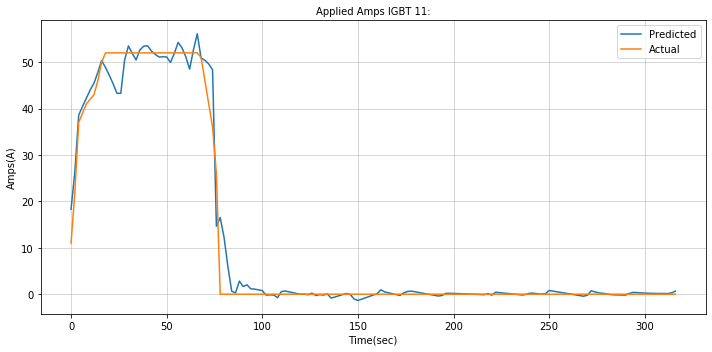

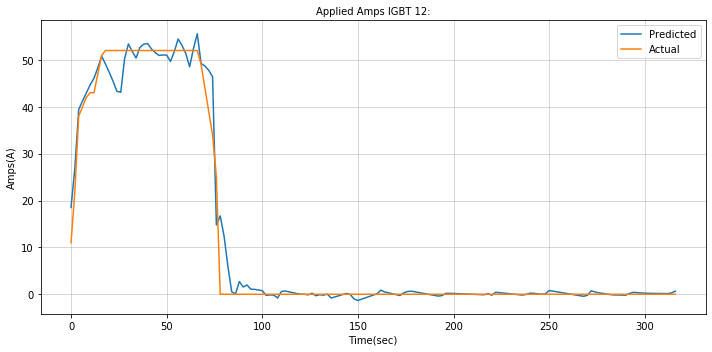

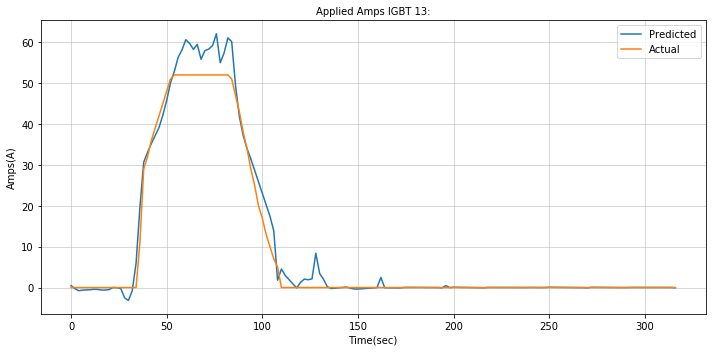

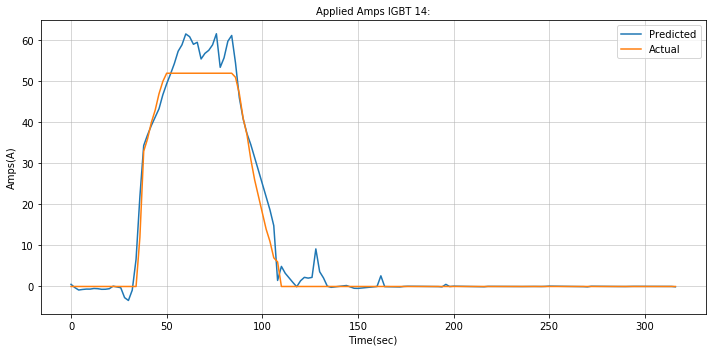

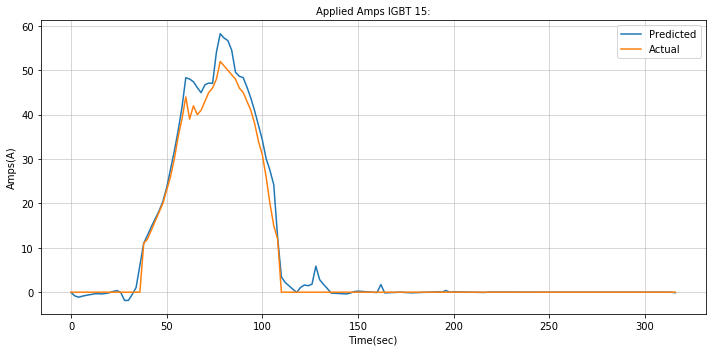

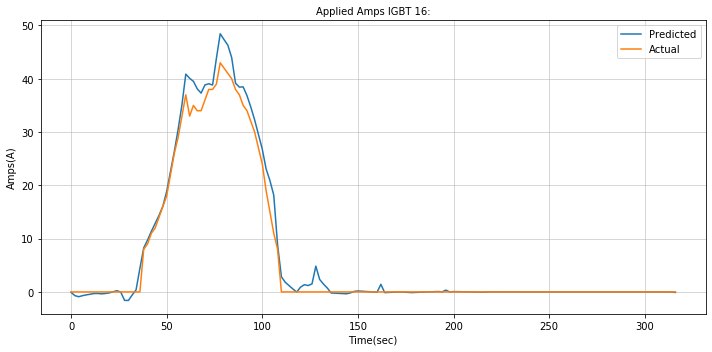

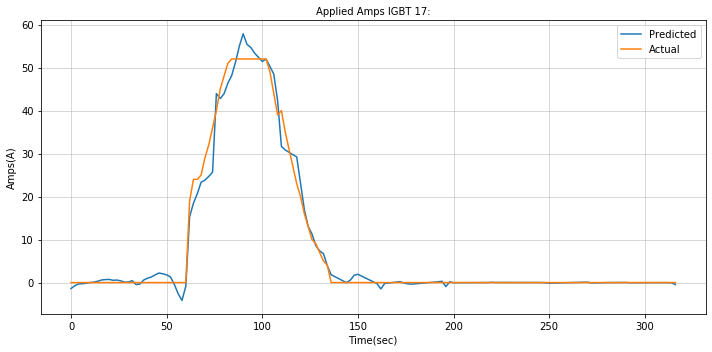

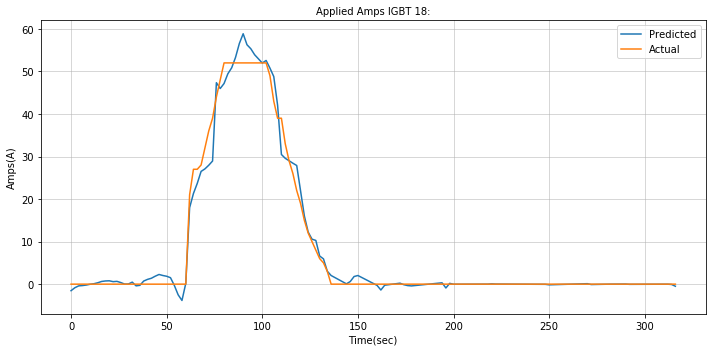

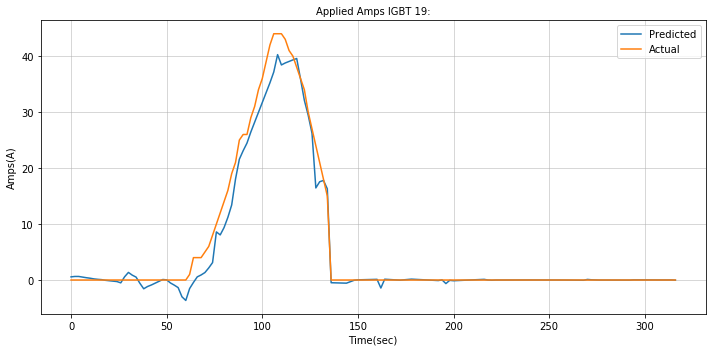

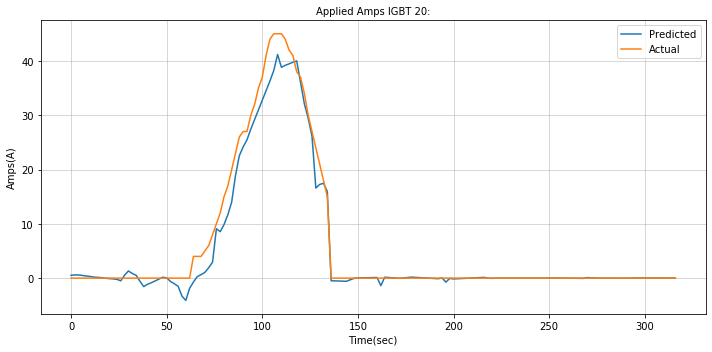

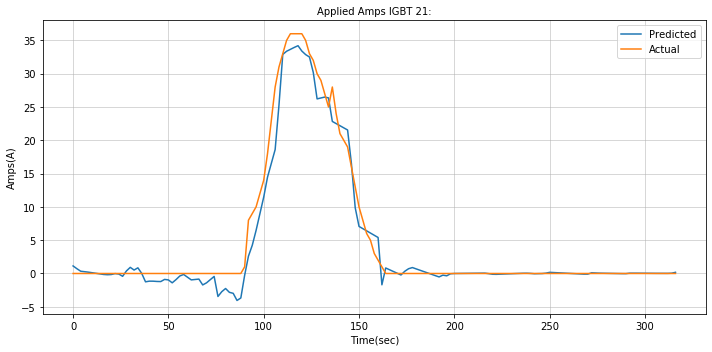

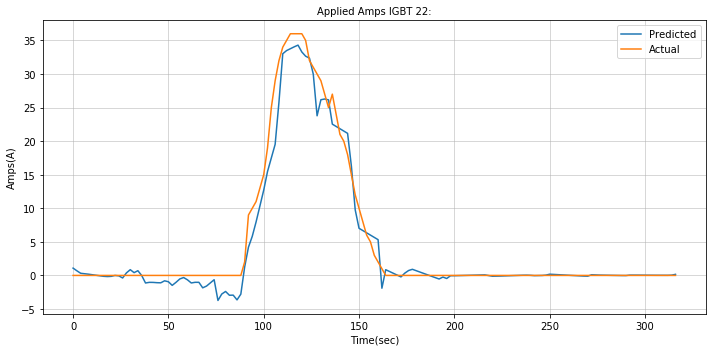

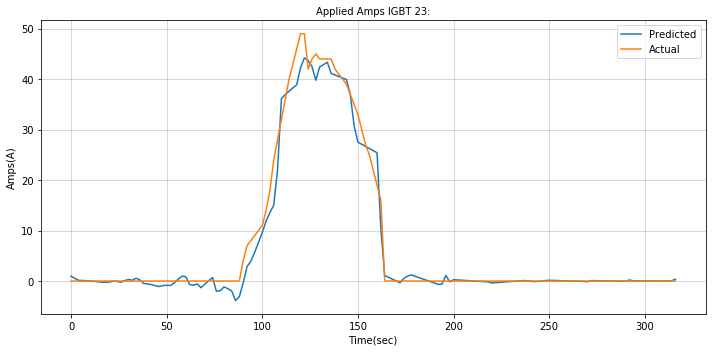

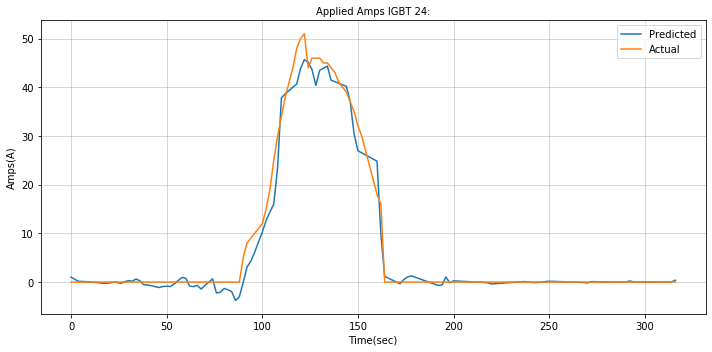

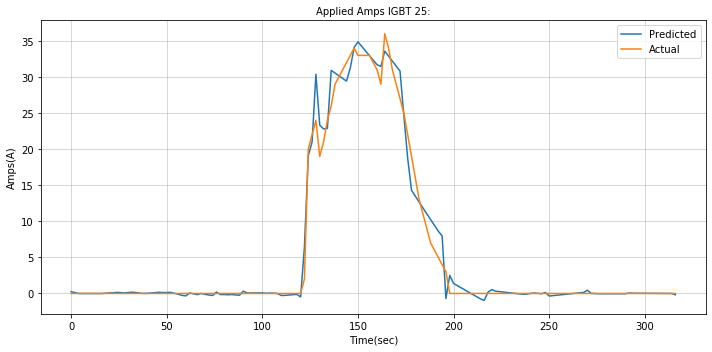

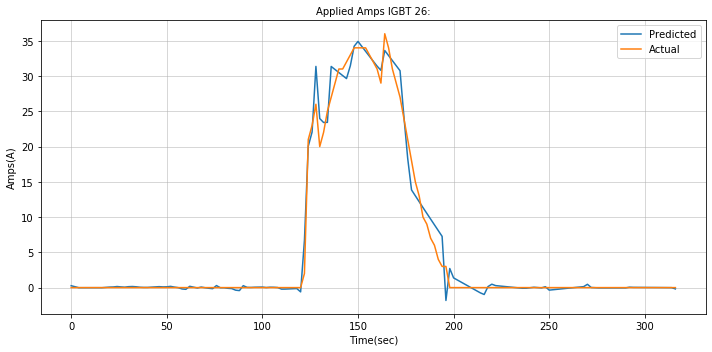

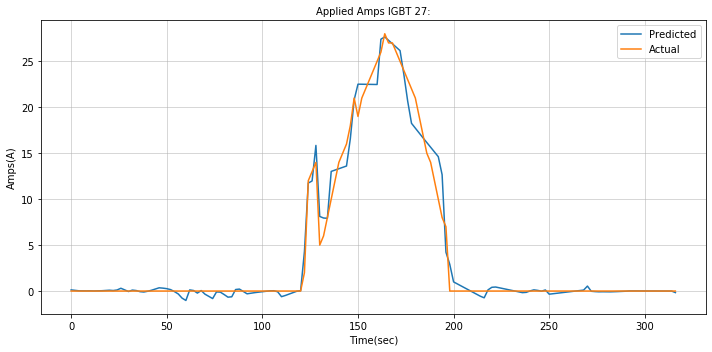

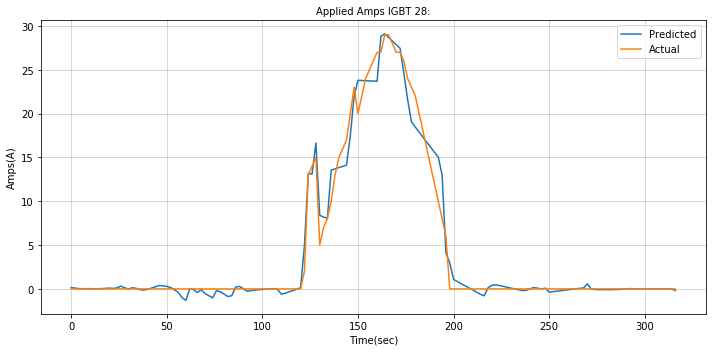

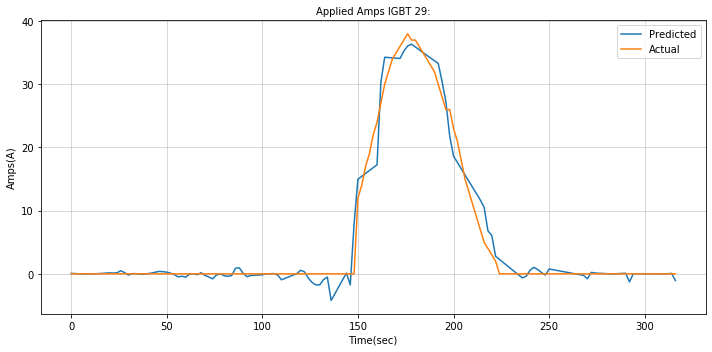

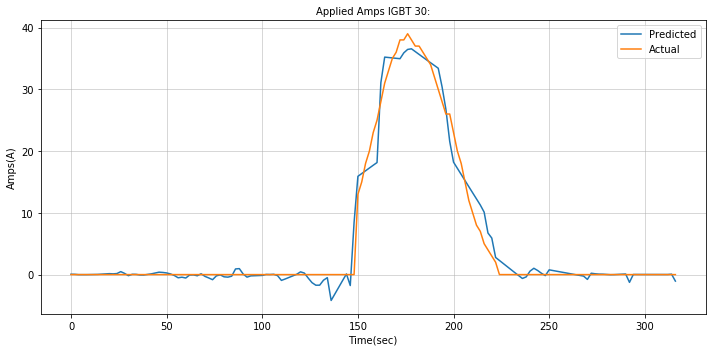

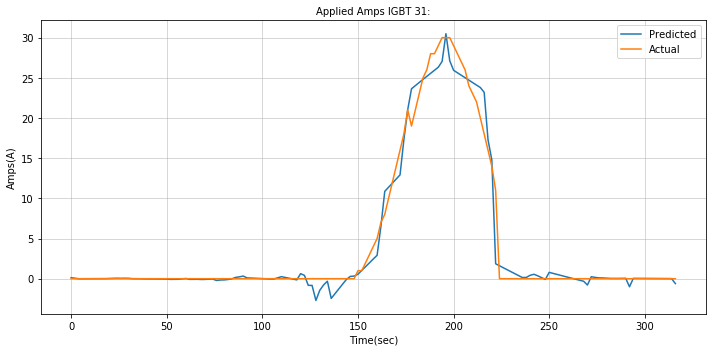

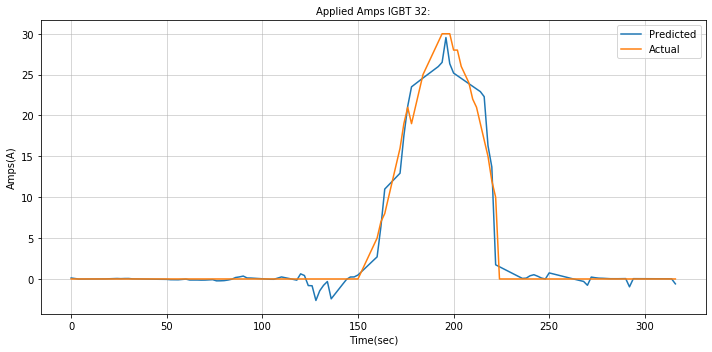

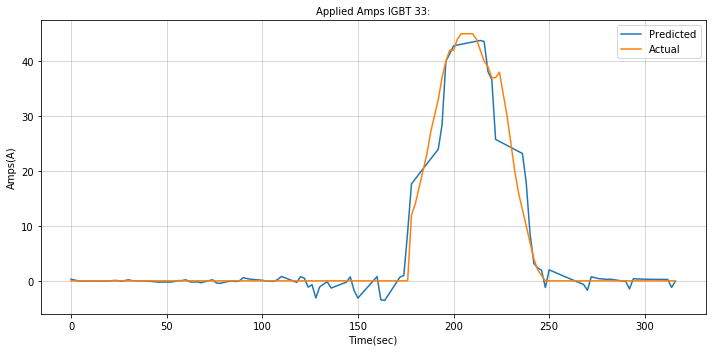

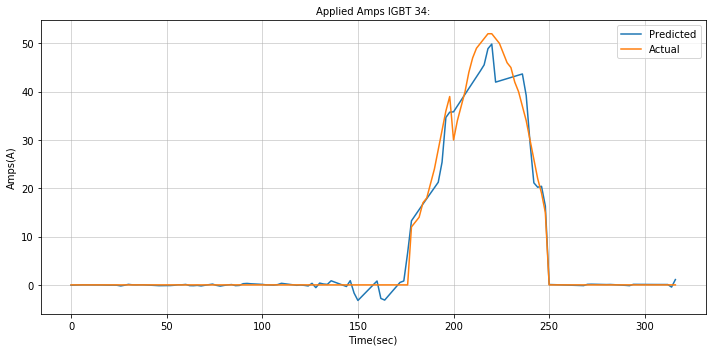

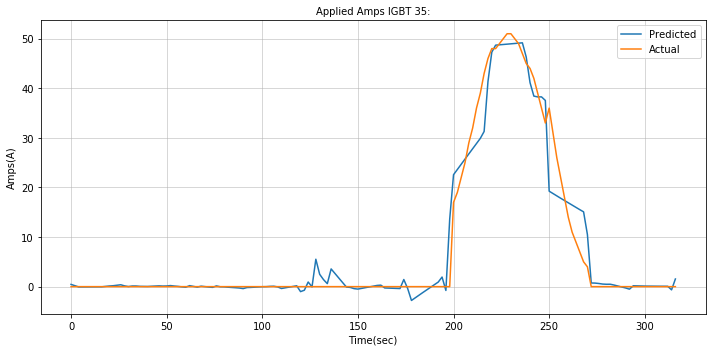

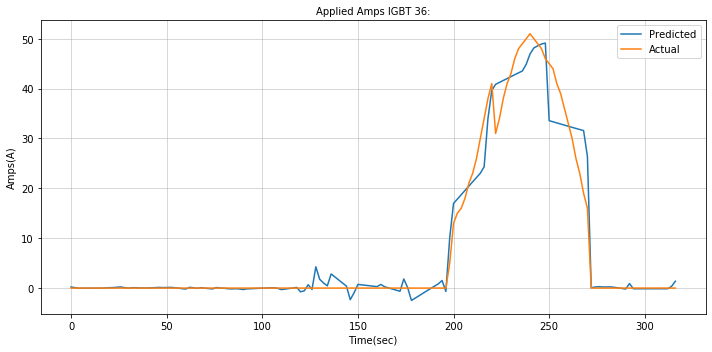

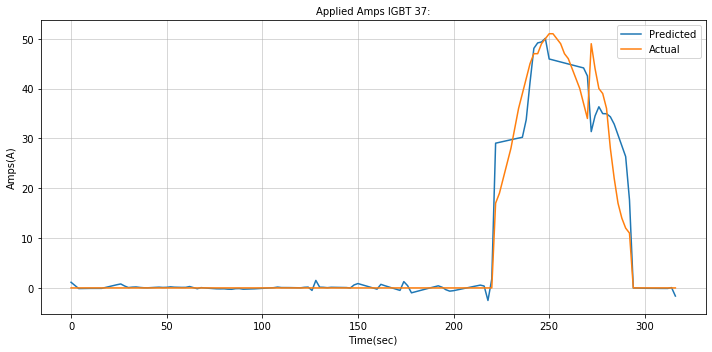

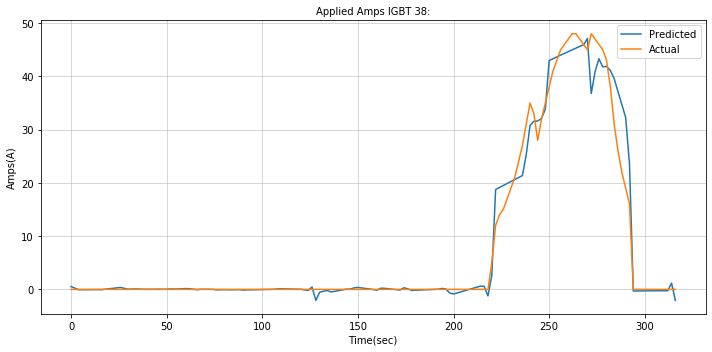

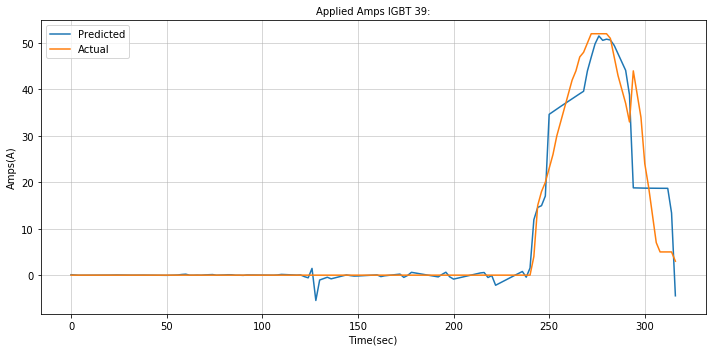

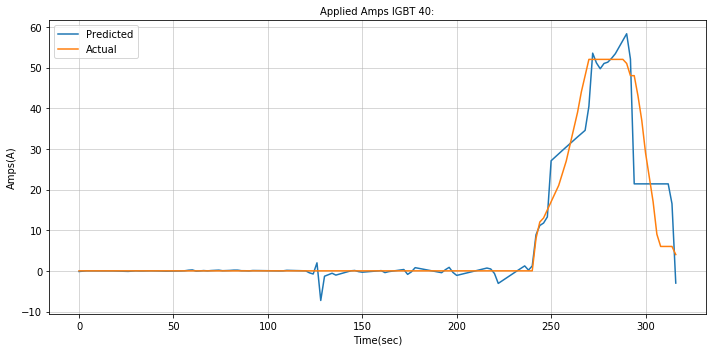

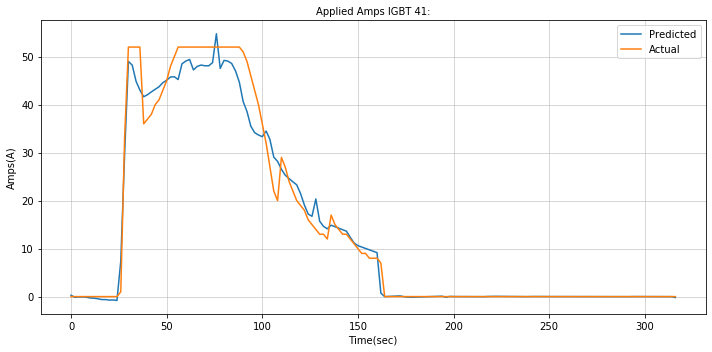

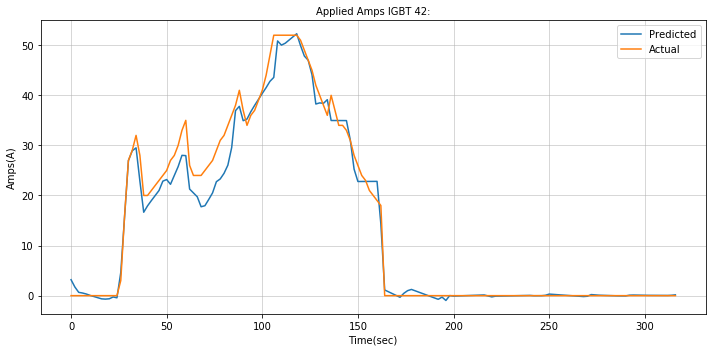

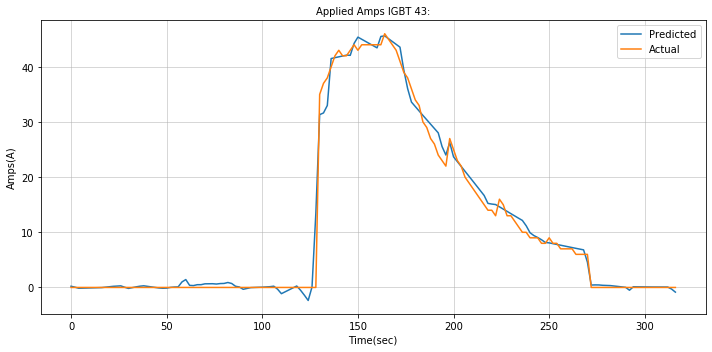

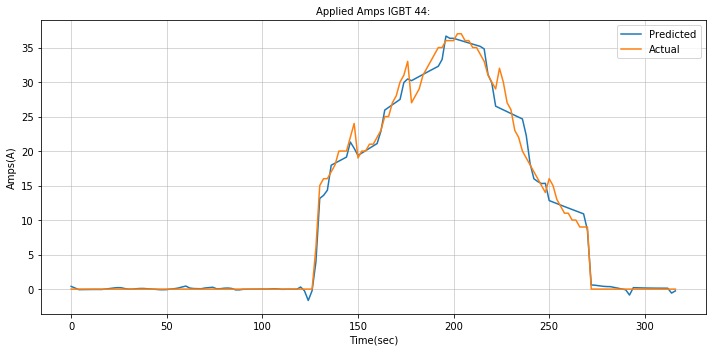

In [78]:
#Visualise targets

plt.rcParams["figure.figsize"] = (10,5)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

for i in range(n_targets):
    plt.plot(test_time,df_predict.iloc[:,i],label='Predicted')
    plt.plot(test_time,df_ytest.iloc[:,i],label='Actual')
    errors = mean_absolute_error(df_ytest.iloc[:,i],df_predict.iloc[:,i])
    plt.title('Applied Amps IGBT %d:' %(i+9),fontsize=10)
    plt.xlabel('Time(sec)',fontsize=10)
    plt.ylabel('Amps(A)',fontsize=10)
    plt.tight_layout()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()


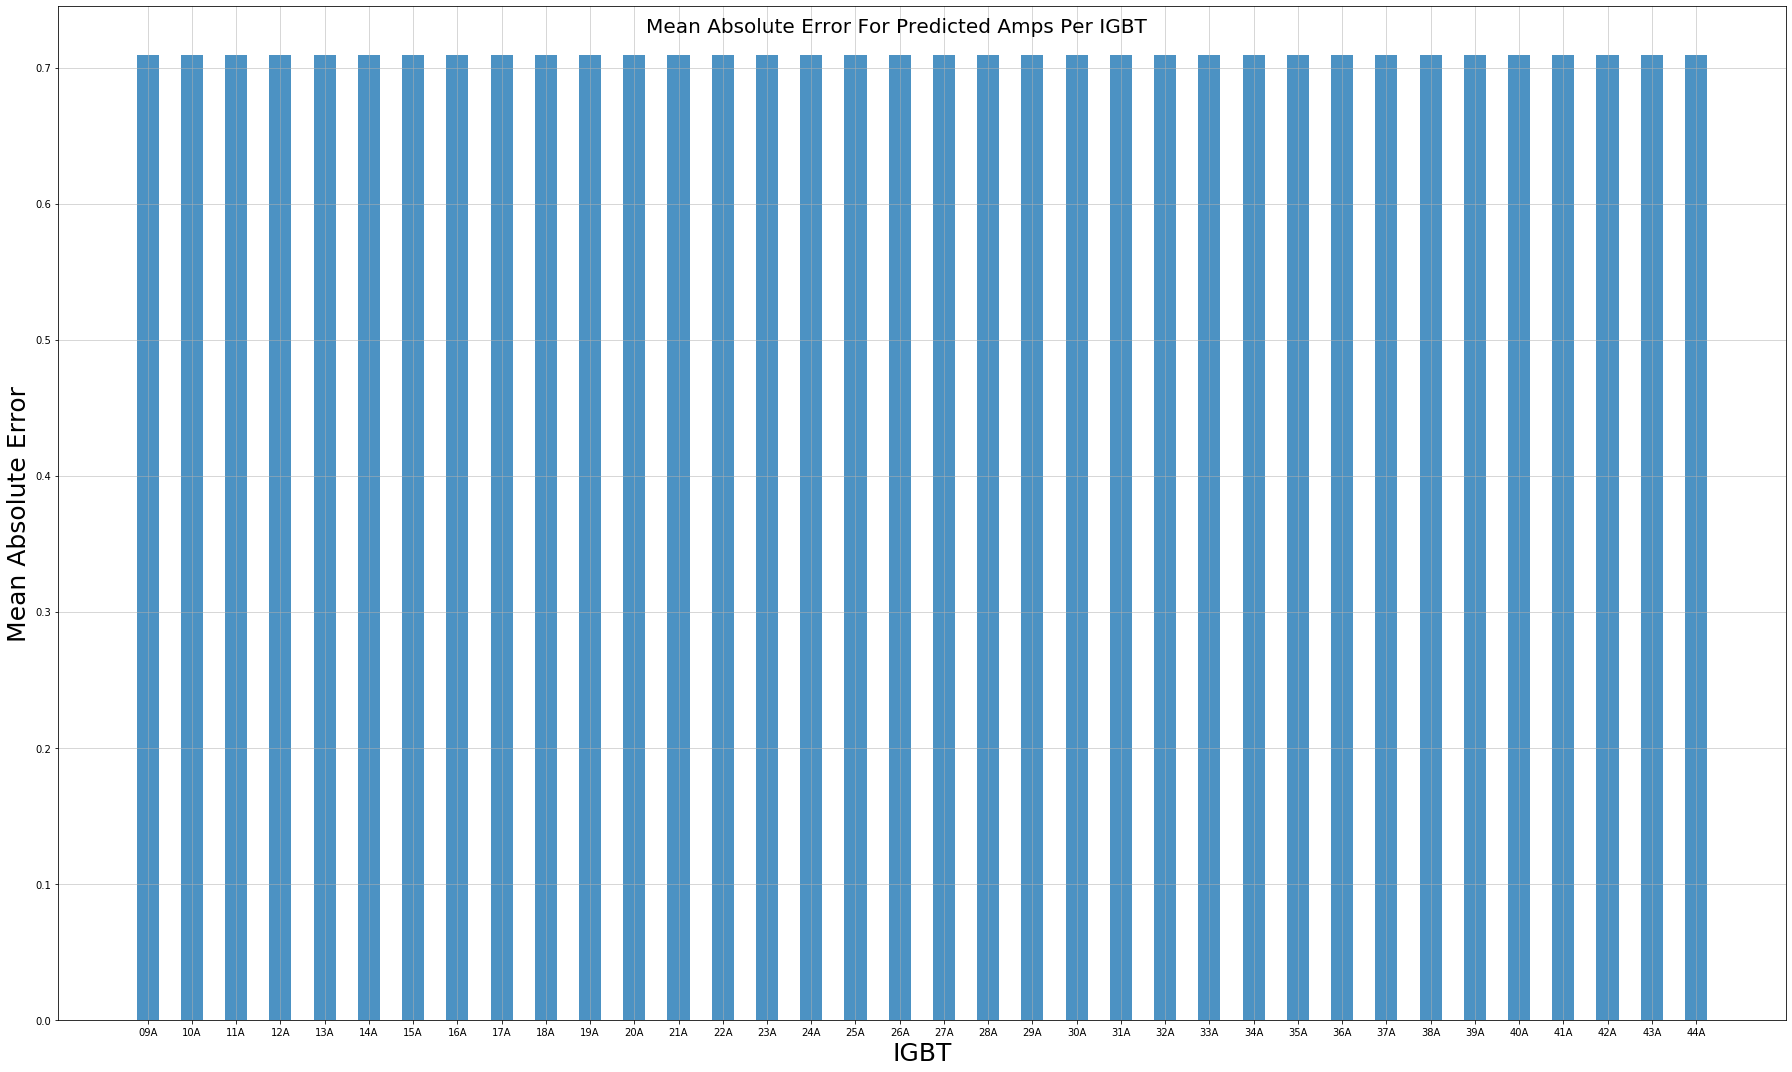

In [79]:
plt.rcParams["figure.figsize"] = (25,15) 

n_groups= df_ytest.columns.size
bar_width = 0.5
opacity=0.8
index = np.arange(n_groups)

plt.bar(index,errors,bar_width,alpha=opacity)
plt.suptitle('Mean Absolute Error For Predicted Amps Per IGBT',fontsize=20)
plt.xlabel('IGBT',fontsize=25)
plt.ylabel('Mean Absolute Error',fontsize=25)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.xticks(index, df_ytest.columns)
plt.grid(linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [80]:
#Write Data to CSV
df_predict.to_csv('Predicted_Model2C.csv')

#Save Model to disk (Quadratic Ridge Model with Optimised Alpha)
fileName='201019_ECModel_AppAmps.pkl'
dump(ridge_model_quad, fileName) 


['201019_ECModel_AppAmps.pkl']